Top modeli po AUC (učna množica)
             Model            Tip                                                                               Parametri Metrike (mean±SD) AIC/BIC Komentar  Izbor
        ExtraTrees       Ensemble                                    {'model__max_depth': 10, 'model__n_estimators': 200}       0.843±0.012     N/A            True
      RandomForest       Ensemble    {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 500}       0.845±0.013     N/A            True
               MLP Neural Network {'model__activation': 'relu', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (50,)}       0.826±0.013     N/A            True
               KNN            KNN                                  {'model__n_neighbors': 9, 'model__weights': 'uniform'}       0.809±0.014     N/A           False
  GradientBoosting       Ensemble       {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}       0.849±0.016     N/A

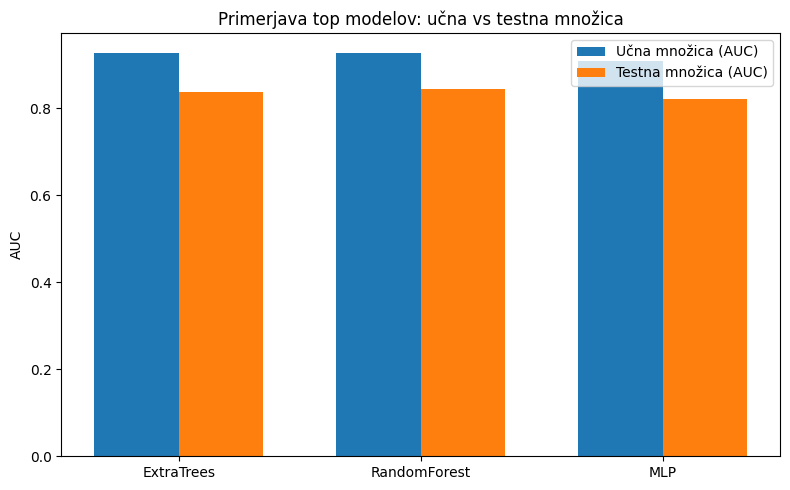

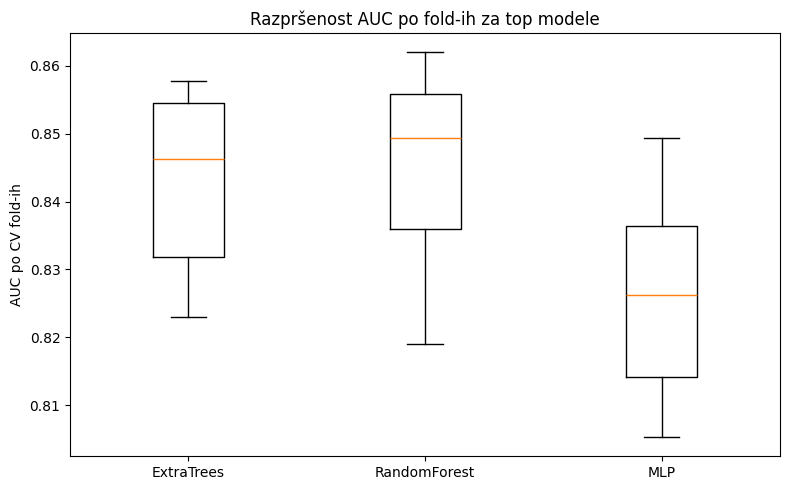

In [2]:
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
    AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

df = pd.read_csv("../Telco-Customer-Churn.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.loc[df["tenure"] == 0, "TotalCharges"] = 0
df["Churn_bin"] = df["Churn"].map({"No": 0, "Yes": 1})

X = df.drop(columns=["Churn", "Churn_bin", "customerID"])
y = df["Churn_bin"]

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models = {
    "LogisticRegression": (
        LogisticRegression(solver='saga', penalty='elasticnet', max_iter=5000),
        {"model__C": [0.01, 0.1, 1, 10],
         "model__l1_ratio":  [0.5, 0.7, 1.0]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {"model__n_estimators":  [100, 200, 500],
         "model__max_depth":  [5, 10, 15, None],
         "model__min_samples_split":  [2, 5, 10]}
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {"model__n_estimators": [100, 200],
         "model__learning_rate":  [0.01, 0.05, 0.1],
         "model__max_depth":  [3, 5, 7]}
    ),
    "ExtraTrees": (
        ExtraTreesClassifier(random_state=42),
        {"model__n_estimators":   [100, 200],
         "model__max_depth":  [5, 10, None]}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {"model__n_estimators":  [50, 100, 200],
         "model__learning_rate":  [0.01, 0.1, 1.0]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"model__n_neighbors": [3, 5, 7, 9], "model__weights": ["uniform", "distance"]}
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {"model__C": [0.1, 1, 10], "model__kernel":  ["linear", "rbf"], "model__gamma": ["scale", "auto"]}
    ),
    "MLP": (
        MLPClassifier(max_iter=5000, random_state=42),
        {"model__hidden_layer_sizes": [(50,), (100,), (50, 50)],
         "model__activation": ["relu"],
         "model__alpha":  [0.0001, 0.001, 0.01]}
    )
}

save_dir = "../modeli_klasifikacija"
os.makedirs(save_dir, exist_ok=True)

results_cv = []

def model_tip_from_name(name):
    if name in {"RandomForest", "ExtraTrees", "GradientBoosting", "AdaBoost"}:
        return "Ensemble"
    if name == "LogisticRegression":
        return "Linear"
    if name == "KNN":
        return "KNN"
    if name == "SVM":
        return "SVM"
    if name == "MLP":
        return "Neural Network"
    return "Drugo"

for name, (model, params) in models.items():
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    grid = GridSearchCV(pipe, params, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    joblib.dump(best_model, os.path.join(save_dir, f"{name}_best_model.pkl"))

    try:
        best_idx = grid.best_index_
        cv_mean = grid.cv_results_["mean_test_score"][best_idx]
        cv_std = grid.cv_results_["std_test_score"][best_idx]
    except Exception:
        cv_mean, cv_std = (None, None)

    y_pred = best_model.predict(X_train)
    y_prob = best_model.predict_proba(X_train)[:, 1] if hasattr(best_model.named_steps['model'], "predict_proba") else None
    try:
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    except Exception:
        tn = fp = fn = tp = 0
    auc = roc_auc_score(y_train, y_prob) if y_prob is not None else None
    acc = accuracy_score(y_train, y_pred)
    sens = tp / (tp + fn) if (tp + fn) > 0 else None
    spec = tn / (tn + fp) if (tn + fp) > 0 else None
    ppv = tp / (tp + fp) if (tp + fp) > 0 else None
    npv = tn / (tn + fn) if (tn + fn) > 0 else None
    f1 = f1_score(y_train, y_pred) if (tp + fp) > 0 and (tp + fn) > 0 else None

    results_cv.append({
        "Model": name,
        "Tip": model_tip_from_name(name),
        "Parametri": grid.best_params_,
        "CV_mean": cv_mean,
        "CV_std": cv_std,
        "AUC": auc,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "F1": f1
    })


df_results = pd.DataFrame(results_cv)

if not df_results.empty:
    df_results["Metrike (mean±SD)"] = df_results.apply(lambda r: (f"{r['CV_mean']:.3f}±{r['CV_std']:.3f}") if pd.notnull(r['CV_mean']) else "N/A", axis=1)
else:
    df_results["Metrike (mean±SD)"] = []


df_results["AIC/BIC"] = "N/A"

df_results["Komentar"] = ""

df_results = df_results.sort_values("AUC", ascending=False).reset_index(drop=True)
df_results["Izbor"] = False
if len(df_results) > 0:
    df_results.loc[0:2, "Izbor"] = True

print("Top modeli po AUC (učna množica)")

cols_order = ["Model", "Tip", "Parametri", "Metrike (mean±SD)", "AIC/BIC", "Komentar", "Izbor"]
print(df_results[cols_order].to_string(index=False))

test_results = []
for name in df_results.head(3)["Model"].tolist():
    model_path = os.path.join(save_dir, f"{name}_best_model.pkl")
    if os.path.exists(model_path):
        pipe = joblib.load(model_path)
    else:
        model, _ = models[name]
        pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
        pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['model'], "predict_proba") else None
    try:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    except Exception:
        tn = fp = fn = tp = 0
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    acc = accuracy_score(y_test, y_pred)
    sens = tp / (tp + fn) if (tp + fn) > 0 else None
    spec = tn / (tn + fp) if (tn + fp) > 0 else None
    ppv = tp / (tp + fp) if (tp + fp) > 0 else None
    npv = tn / (tn + fn) if (tn + fn) > 0 else None
    f1 = f1_score(y_test, y_pred) if (tp + fp) > 0 and (tp + fn) > 0 else None

    test_results.append({
        "Model": name,
        "Tip": model_tip_from_name(name),
        "Parametri": pipe.named_steps['model'].get_params() if hasattr(pipe.named_steps['model'], 'get_params') else {},
        "Metrike": auc,
        "AIC/BIC": "N/A",
        "Komentar": "",
        "Izbor": True
    })

if test_results:
    df_test = pd.DataFrame(test_results)
else:
    df_test = pd.DataFrame(columns=["Model", "Tip", "Parametri", "Metrike", "AIC/BIC", "Komentar", "Izbor"])

print("\nRezultati na testni množici")
print(df_test.to_string(index=False))

try:
    top_models = df_results.head(3)["Model"].tolist()
    train_auc = []
    test_auc = []
    cv_scores = {}  # za boxplot

    for m in top_models:
        # pridobi AUC po CV fold-ih
        model_path = os.path.join(save_dir, f"{m}_best_model.pkl")
        pipe = joblib.load(model_path)
        grid = GridSearchCV(
            pipe,
            models[m][1],
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            refit=False
        )
        grid.fit(X_train, y_train)
        # Shrani vse fold AUC
        fold_scores = []
        for i in range(cv.get_n_splits()):
            fold_scores.append(grid.cv_results_[f"split{i}_test_score"][grid.best_index_])
        cv_scores[m] = fold_scores

        # Povprečja za bar chart
        train_auc.append(df_results.set_index('Model')['AUC'].get(m, 0))
        test_auc.append(df_test.set_index('Model')['Metrike'].get(m, 0))

    x = np.arange(len(top_models))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, train_auc, width, label='Učna množica (AUC)')
    plt.bar(x + width/2, test_auc, width, label='Testna množica (AUC)')
    plt.xticks(x, top_models)
    plt.ylabel('AUC')
    plt.title('Primerjava top modelov: učna vs testna množica')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.boxplot([cv_scores[m] for m in top_models], labels=top_models)
    plt.ylabel('AUC po CV fold-ih')
    plt.title('Razpršenost AUC po fold-ih za top modele')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Napaka pri risanju grafa: {e}")



### Top modeli po AUC (učna množica)

| Model             | Tip             | Parametri                                                                                      | Metrike (mean±SD) | Komentar | Izbor |
|------------------|----------------|------------------------------------------------------------------------------------------------|-----------------|---------|-------|
| ExtraTrees       | Ensemble       | {'model__max_depth': 10, 'model__n_estimators': 200}                                           | 0.843±0.012     |          | True  |
| RandomForest     | Ensemble       | {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 500}          | 0.845±0.013     |          | True  |
| MLP              | Neural Network | {'model__activation': 'relu', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (50,)}       | 0.826±0.013     |         | True  |
| KNN              | KNN            | {'model__n_neighbors': 9, 'model__weights': 'uniform'}                                        | 0.809±0.014     |          | False |
| GradientBoosting | Ensemble       | {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}             | 0.849±0.016     |         | False |
| AdaBoost         | Ensemble       | {'model__learning_rate': 1.0, 'model__n_estimators': 200}                                     | 0.848±0.016     |         | False |
| LogisticRegression | Linear       | {'model__C': 10, 'model__l1_ratio': 0.5}                                                      | 0.846±0.015     |        | False |
| SVM              | SVM            | {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}                         | 0.834±0.015     |         | False |

### Rezultati na testni množici

| Model        | Tip            | Parametri                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | Metrike  | Komentar | Izbor |
|--------------|----------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|----------|-------|
| ExtraTrees   | Ensemble       | {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}                                                                 | 0.838293 |          | True  |
| RandomForest | Ensemble       | {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}                                                                  | 0.844079 |          | True  |
| MLP          | Neural Network | {'activation': 'relu', 'alpha': 0.01, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 5000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False} | 0.820657 |          | True  |

